<a href="https://colab.research.google.com/github/amishfaldu-njit/eng-ai-agents/blob/main/assignments/assignment-1/assignment1_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import math
import torch.distributions as dist
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt

%matplotlib inline

## Development Environment Setup

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print(torch.cuda.current_device())
    print(torch.cuda.device_count())
    print(torch.cuda.get_device_name(0))

device

0
1
Tesla T4


device(type='cuda', index=0)

## Information Theory Basics

In [3]:
# Define the joint probability distribution p_xy (rows: Y=1,2,3,4; columns: X=1,2,3,4)
p_xy = torch.tensor([
    [1/8,   1/16,  1/32,  1/32],
    [1/16,  1/8,   1/32,  1/32],
    [1/16,  1/16,  1/16,  1/16],
    [1/4,   0,     0,     0   ]
], dtype=torch.float64)

# Compute marginal distributions
p_y = p_xy.sum(dim=1)  # Marginal for Y (shape: [4])
p_x = p_xy.sum(dim=0)  # Marginal for X (shape: [4])

# Entropy function using log base 2; clamp to avoid log(0)
def entropy(p):
    p_safe = p.clamp(min=1e-12)
    return -(p_safe * torch.log2(p_safe)).sum()

# Compute H(X) and H(Y)
H_X = entropy(p_x)
H_Y = entropy(p_y)

# Compute conditional entropy H(X|Y)
# p(x|y) = p(x,y)/p(y); use broadcasting (p_y.unsqueeze(1) makes p_y shape [4,1])
p_x_given_y = p_xy / p_y.unsqueeze(1)
H_X_given_y = -(p_x_given_y * torch.log2(p_x_given_y.clamp(min=1e-12))).sum(dim=1)  # H(X|y) for each y
H_X_given_Y = (p_y * H_X_given_y).sum()

# Compute conditional entropy H(Y|X)
# p(y|x) = p(x,y)/p(x); p_x.unsqueeze(0) makes p_x shape [1,4]
p_y_given_x = p_xy / p_x.unsqueeze(0)
H_Y_given_x = -(p_y_given_x * torch.log2(p_y_given_x.clamp(min=1e-12))).sum(dim=0)  # H(Y|x) for each x
H_Y_given_X = (p_x * H_Y_given_x).sum()

# Mutual Information I(X;Y) = H(X) - H(X|Y)
I_XY = H_X - H_X_given_Y

# Print the results
print(f"H(X)      = {H_X:.3f} bits")
print(f"H(Y)      = {H_Y:.3f} bits")
print(f"H(X|Y)    = {H_X_given_Y:.3f} bits")
print(f"H(Y|X)    = {H_Y_given_X:.3f} bits")
print(f"I(X, Y)   = {I_XY:.3f} bits")

# Verify that H(X)-H(X|Y) equals H(Y)-H(Y|X)
print(f"H(X) - H(X|Y) = {H_X - H_X_given_Y:.3f} bits")
print(f"H(Y) - H(Y|X) = {H_Y - H_Y_given_X:.3f} bits")

# Check if H(X|Y) == H(Y|X)
print(f"Is H(X|Y) == H(Y|X)? {torch.isclose(H_X_given_Y, H_Y_given_X)}")

# Check if H(X) - H(X|Y) == H(Y) - H(Y|X)
print(f"Is H(X) - H(X|Y) == H(Y) - H(Y|X)? {torch.isclose(H_X - H_X_given_Y, H_Y - H_Y_given_X)}")

H(X)      = 1.750 bits
H(Y)      = 2.000 bits
H(X|Y)    = 1.375 bits
H(Y|X)    = 1.625 bits
I(X, Y)   = 0.375 bits
H(X) - H(X|Y) = 0.375 bits
H(Y) - H(Y|X) = 0.375 bits
Is H(X|Y) == H(Y|X)? False
Is H(X) - H(X|Y) == H(Y) - H(Y|X)? True


## Maximum Liklihood Parameter Estimation

### Task-1

In [4]:
# Task 1: Simulate interarrival times
lambda_true = 100  # True rate parameter
num_samples = 1000  # Number of interarrival times to simulate

# Exponential distribution with rate lambda_true
exponential_dist = dist.Exponential(rate=lambda_true)
interarrival_times = exponential_dist.sample((num_samples,))

### Task-2

True lambda: 100
Estimated lambda: 99.40155792236328


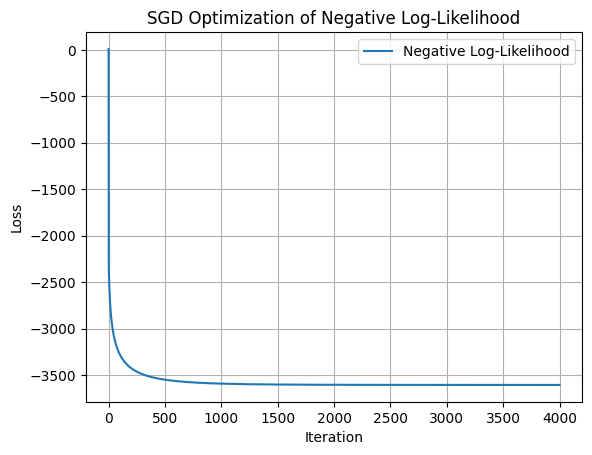

In [5]:
# Task 2: Estimate lambda using SGD
# Initialize lambda as a learnable parameter
lambda_est = torch.tensor(1.0, requires_grad=True)

# SGD hyperparameters
learning_rate = 0.01
num_iterations = 4000
loss_history = []

# SGD optimizer
optimizer = torch.optim.SGD([lambda_est], lr=learning_rate)

# Training loop
for i in range(num_iterations):
    # Compute negative log-likelihood
    nll = -torch.sum(torch.log(lambda_est) - lambda_est * interarrival_times)

    # Backpropagation
    optimizer.zero_grad()
    nll.backward()
    optimizer.step()

    # Ensure lambda_est stays positive
    with torch.no_grad():
        lambda_est.clamp_(min=1e-6)

    # Store loss for plotting
    loss_history.append(nll.item())

# Output results
print(f"True lambda: {lambda_true}")
print(f"Estimated lambda: {lambda_est.item()}")

# Plot the loss over iterations
plt.plot(range(num_iterations), loss_history, label="Negative Log-Likelihood")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("SGD Optimization of Negative Log-Likelihood")
plt.legend()
plt.grid()
plt.show()

## Linear Regression and SGD

### Dataset

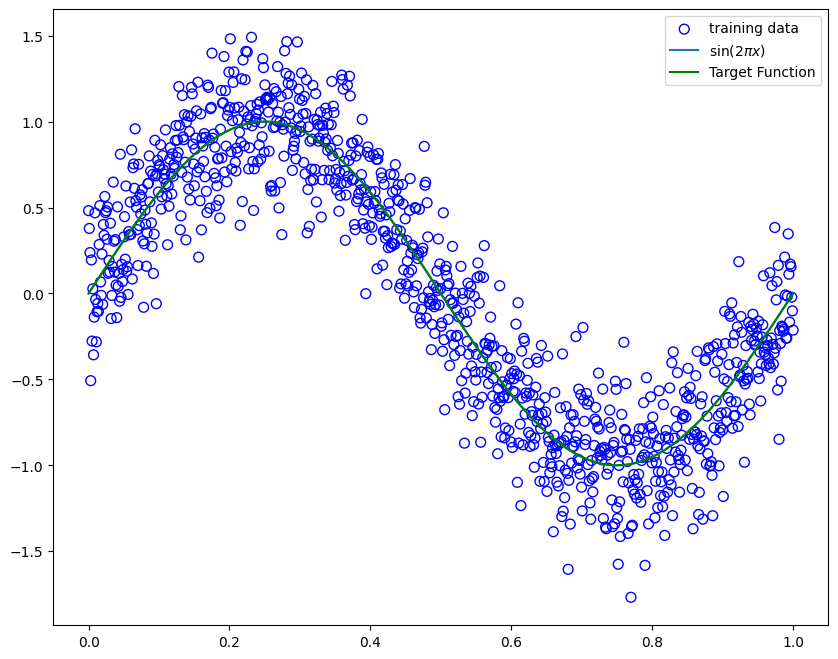

In [6]:
# Set random seed for reproducibility
torch.manual_seed(42)

# data params
num_samples = 1000
num_features = 1

# Data creation function
def create_toy_data(func, sample_size, std, domain=[0, 1]):
    x = torch.linspace(domain[0], domain[1], sample_size)
    y = func(x) + torch.normal(mean=0.0, std=std, size=x.shape)
    return x, y

# Sin waveform function
def sinusoidal(x):
    return torch.sin(2 * math.pi * x)

# Train and test data split
X_train, y_train = create_toy_data(sinusoidal, num_samples, 0.25)

X_test = torch.linspace(0, 1, 100)
y_test = sinusoidal(X_test)

# Plot data
plt.figure(figsize=[10,8])
plt.scatter(X_train, y_train, facecolor="none", edgecolor="b", s=50, label="training data")
plt.plot(X_test, y_test, label="$\sin(2\pi x)$")
plt.plot(X_test, y_test, "-g", label="Target Function")
plt.legend()
plt.show()

### Modelling

In [7]:
# Hyperparameters
learning_rate = 0.01
lambda_reg = 0.01  # Regularization strength
num_epochs = 1000
batch_size = 32

In [8]:
# Initialize parameters
weights = torch.normal(0, 1, (num_features,), requires_grad=True)
bias = torch.normal(0, 1, (1,), requires_grad=True)

In [9]:
# Training loop
loss_history = []

for epoch in range(num_epochs):
    # Shuffle data
    permutation = torch.randperm(num_samples)
    X_shuffled = X_train[permutation]
    y_shuffled = y_train[permutation]

    # Mini-batch SGD
    for i in range(0, num_samples, batch_size):
        # Get mini-batch
        X_batch = X_shuffled[i:i + batch_size]
        y_batch = y_shuffled[i:i + batch_size]

        # Forward pass: compute predictions
        y_pred = weights * X_batch + bias

        # Compute loss (MSE + L2 regularization)
        mse_loss = torch.mean((y_pred - y_batch) ** 2)
        l2_reg = lambda_reg * torch.sum(weights ** 2)
        loss = mse_loss + l2_reg

        # Backward pass: compute gradients
        loss.backward()

        # Update parameters
        with torch.no_grad():
          weights -= learning_rate * weights.grad
          bias -= learning_rate * bias.grad

        # Zero gradients
        weights.grad.zero_()
        bias.grad.zero_()

    # Store loss for plotting
    loss_history.append(loss.item())

    # Print progress
    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}")

Epoch [100/1000], Loss: 0.4121
Epoch [200/1000], Loss: 0.2709
Epoch [300/1000], Loss: 0.2571
Epoch [400/1000], Loss: 0.1956
Epoch [500/1000], Loss: 0.1368
Epoch [600/1000], Loss: 0.2674
Epoch [700/1000], Loss: 0.3097
Epoch [800/1000], Loss: 0.3275
Epoch [900/1000], Loss: 0.4313
Epoch [1000/1000], Loss: 0.5201


Final weights: [-1.7297102]
Final bias: 0.8670


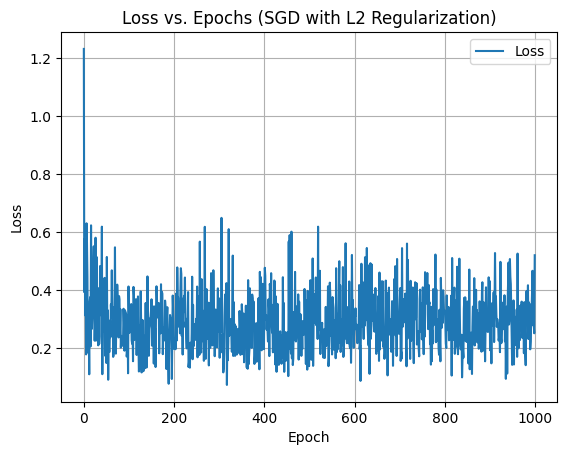

In [10]:
# Final parameter values
print(f"Final weights: {weights.detach().numpy()}")
print(f"Final bias: {bias.item():.4f}")

# Plot loss vs. epochs
plt.plot(range(num_epochs), loss_history, label="Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs. Epochs (SGD with L2 Regularization)")
plt.legend()
plt.grid()
plt.show()